# Investment and Trading Capstone Project
## Stock Price Forecasting
### Udacity MLND
#### Author: Louis Jacome

## Project Overview
    
In the following project we take a machine learning approach to the problem of predicting the future price of a company's stock. The motivation behind using a machine learning algorithm is the ease in incorporating multiple variables that describe a stock's trend (technical indicators) into a model as features that improve forecasting accuracy over a time-series analysis that typically uses fewer indicators. Additionally the lack of cognitive bias eliminates the prospect of human error in forecasting via overconfidence in a few technical indicators and/or one's intuition. This last point is important in the context of the efficient-market hypothesis (EMH) which posits that a stock price at a given time incorporates all relevant information at that time. In practical terms a market following EMH would be unpredictable as prices fluctuate based on  unknowable (future) information so one's odds at correctly predicting the movement of a stock price in the long run would be no better than a coin-flip.

The degree to which the EHM describes actual markets is still unclear though, given instances of success in using historical information to infer trends not describeable by an EHM random-walk. Spurred by this prospect, we proceed in the following project by pulling daily raw financial data from the Intrinio web-API (https://intrinio.com). Using the daily adjusted closing price (ACP, the price of the last stock sold on a day adjusted by corporate actions including dividends and splits) we calculate 3 distinct features for 4 companies and 2 corresponding market indices. The features include volatility in the percent change of the ACP, the  increasing or decreasing momentum of the ACP, and finally the ACP's set of Bollinger bands. We then train an AdaBoost regressor to predict the ACP a variable number of days beyond the training dataset and compare by relative difference to the actual day's recorded ACP.

##### Metrics

Later on in the project as we visualize the performance of our model using a learning and model complexity curve, we opt to use the relative difference to better showcase how our model behaves. We use the following expression to calculate the relative difference:
$$  \left|\frac{ y_i-y_i^{(p)}}{max( y_i,\ y_i^{(p)})}\right| $$
where $y_i^{(p)}$ are predicted target values and $y_i$ are actual target values. We use the relative difference to eliminate the scale difference between stock prices, as well as the clarity in having a linear scale that shows exactly how close to the actual stock price our model's predictions are.
An alternative performance metric for a regression model is the coefficient of determination or $R^2$. $R^2$ is defined as:
$$R^2 =  1 - \frac{\sum_{i=1}^n( \ y_i^{(p)} - y_i \ )^2}{\sum_{i=1}^n ( \ y_i-\bar{y} \ )^2} $$

where $\bar{y}$ is the target mean. In the rational expression, the numerator is the sum of squared errors of the prediction while the denominator is the variance of the target data; the ratio then compares the amount of variance in the predicted target to the actual target data. In cases where a regression is formed from training data, $R^2$ returns a value that is often interpreted as a perctange as it falls within the range $[0,1]$. But for some cases where the test data does not share similar distribution to the training data the prediction squared error could be large resulting in an $R^2$ with an upper bound but no lower bound--large negative scores that do not provide much insight.

In [1]:
import sys
import os
sys.path.append(os.getcwd())
from predictor import *
from visuals import *
from utility import*
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## Analysis
##### Data Exploration

The intrinio web-API allows one to request daily raw financial data from as far back as 1970s though for most companies data only goes to 1996. Using the U.S. Public Company Data Feed we can request stock data: volume, open, high, low, close prices with corresponding adjusted values, as well as split ratio, and ex dividend. From the available stock data we use just the adjusted close value to both compute our technical indicators and use the raw value to serve as the target for our regressor. Also through the API, we request the daily stock market index for both the S&P 500 and S&P 100 and perform the same computation on the raw index value to arrive at the features. In the following example we acquire historic stock data from 4 companies: BAC (Bank of America), AAPL (Apple), QCOM (Qualcomm), and Amazon (AMZN) starting from January 4th, 2010 and ending in February 6th, 2017. There are approximately 252 trading days in a year which gives us 1,786 trading days to build our model.

In [2]:
#For convenience of this report, data is loaded from file. The GUI that 
#accompanies this report allows one to specify index and stock data by 
#market symbols.
def from_file():
    '''Load stock price and index value data from file'''
    data = pd.DataFrame.from_csv('large_dataset_nodates.csv')
    print 'Imported data from file'
    return data

data = from_file()

select_cols = [column for column in data.columns if 'close' in column]
print '\n', 'Number of trading days in dataset: {}'.format(len(data)), '\n'
print 'Available data: ', [column for column in data.columns], '\n'
display(data[select_cols][:5]), 
display(data[select_cols].describe())


Imported data from file

Number of trading days in dataset: 1786 

Available data:  ['adj_close_BAC', 'high_BAC', 'low_BAC', 'open_BAC', 'volume_BAC', 'adj_close_AAPL', 'high_AAPL', 'low_AAPL', 'open_AAPL', 'volume_AAPL', 'adj_close_AMZN', 'high_AMZN', 'low_AMZN', 'open_AMZN', 'volume_AMZN', 'adj_close_QCOM', 'high_QCOM', 'low_QCOM', 'open_QCOM', 'volume_QCOM', 'close_price_$NDX', 'close_price_$SPX'] 



,adj_close_BAC,adj_close_AAPL,adj_close_AMZN,adj_close_QCOM,close_price_$NDX,close_price_$SPX
1486368000,23.12,130.29,807.64,52.88,1013.690002,2297.419922
1486108800,23.29,129.08,810.20,52.98,1013.690002,2297.419922
1486022400,22.72,128.53,839.95,52.66,1006.150024,2280.850098
1485936000,22.89,128.75,832.35,53.15,1006.330017,2279.550049
1485849600,22.64,121.35,823.48,53.43,1004.460022,2278.870117


,adj_close_BAC,adj_close_AAPL,adj_close_AMZN,adj_close_QCOM,close_price_$NDX,close_price_$SPX
count,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000
mean,13.281769,75.943399,344.243169,54.923363,739.217525,1654.198039
std,3.661559,28.992930,195.562623,11.163698,160.472659,375.898711
min,4.778050,24.989762,108.610000,27.593003,463.839996,1022.580017
25%,11.126840,50.669166,194.130000,47.949692,587.972489,1313.087494
50%,13.972820,73.745297,287.075000,55.435773,742.769989,1656.114990
75%,15.774947,103.003209,422.597500,64.228852,899.390000,2032.070007
max,23.440000,130.290000,844.360000,75.519355,1013.690002,2298.370117


The dataset is formed by requesting individual stock and index data from the intrinio API, the data is then organized by date (converted to epoch which forms the DataFrame index) and merged into a single DataFrame according to the index. For this dataset, there is one more trading day for stocks than indices, so the index value prior to the final day is used for the last day for S&P 500 and S&P 100 indices. In the dataset we use only the ACP for each stock and close price for each index only because our small set of features uses just this data. There are a variety of technical indicators available that make use of any one or a combination of the data, for example a popular indicator is the On Balance Volume (OBV) which describes volume momentum by weighting the volume over time as positive or negative depending on the stock price momentum. Observing the raw data and statistics, we find a large difference in scale between the ACP of different companies; for example the mean Amazon ACP is greater than the ACPs of BAC, AAPL, and QCOM by a factor of 25.9, 4.5, and 6.3 respectively. Additionally because we are attempting to model the trends in a time series, outliers are not removed as we want our model to be sensitive to large fluctations that may result when a company is subject to good or bad news.

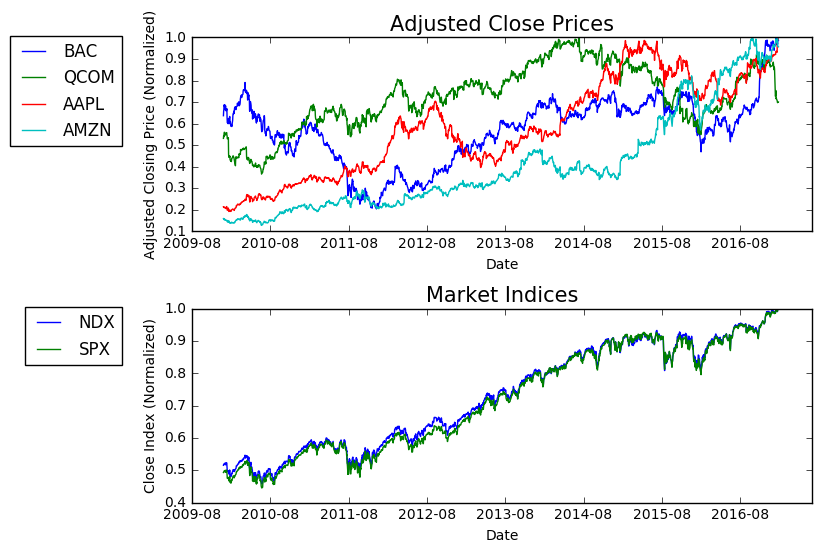

In [3]:
%matplotlib inline
data_fig1 = data_plotter(data)

The relevant time series for each stock and market index is normalized by the max value for each to allow us to compare their long timescale behavior. In the case of the market indices, the S&P 500 (NDX) and S&P 100 (SPX) appear nearly identical over the long timescale, which can be expected due to the S&P 100 being a subset of the S&P 500 (accounting for approx. 57% market capitalization of the S&P 500). Over 7 years the closing index increased by 50% for both indices as expected in the postrecession recovery. Observing the individual stocks we again see a gradual increase in price over 7 years but also notice less correlation between the stocks as well as a higher short-term variance. At specific times we even see swings of 50% for BAC over a year, and 30% for AMZN over a few months. In a later section when we compute our features we want them to capture both the general movement of the stock and index as well as the sporadic dips present in the dataset.

##### Algorithms and Techniques

As previously noted, we use an AdaBoost regressor to form our model and make predictions on future stock prices. AdaBoost is a type of ensemble method which are a class of methods that combine an ensemble of weak learners (classifiers or regressors) to form a robust learner that makes much more accurate predictions that any one weak learner. Within the ensemble methods, AdaBoost further falls into the category of a boosting method which describe methods that linearly combine weak learners into a robust learner. Although the final learner is a result of a linear combination, it is fully capable of tackling nonlinear problems given that the weak learners do not assume the problem at hand is linear. For this reason we choose not to use the similarly robust linear regression. Furthermore AdaBoost requires less tuning than a Support Vector Machine (SVM) or Artifical Neural Network (ANN) which means we spend less effort tweaking our model when we add more features, and lastly the AdaBoost is computationally simple which allows for better scaling to much larger datasets (e.g. every stock in the S&P 500) with a richer set of features. We now review the details of the AdaBoost regression algorithm included in the scikit-learn library.

We first define $(x_i, y_i), 1 \leq i \leq N$ where $N$ is the total number of days in our dataset, $x_i$ is a vector containing every feature for a given day $i$ and $y_i$ is the corresponding target ACP. We proceed by listing step-by-step the AdaBoost R2 [1] algorithm. 

__1)__ A weight $w_i$ is assigned to each vector $x_i$, initially set as $w_i=1$  for $i=1,...,N$. The probability of training on data from day $i$ is given by
$$p_i=\frac{w_i}{\sum_{i}w_i} \\\\ $$

__2)__ A weak regressor constructs a hypothesis (discussed later), $h_t$, from the training data. $\\\\$
$$ h_t:x \rightarrow y \\\\ $$

__3)__ A prediction of the ACP is made by the weak regressor $h_t$ : $y_i^{(p)}(x_i) \hspace{0.25cm} i=1,...,N \\\\$ 

__4)__ For each trading day the value of a loss function $L_i$ is computed that describes the error in prediction. $L_i = L\left( \left| \  y_i^{(p)}(x_i) - y_i \ \right|\right) $ where $L \in [0,1]$ through normalization by factor $D=sup \left| \ y_i^{(p)}(x_i) - y_i \ \right| \\\\ $.

__5)__ The average loss, $\bar{L}$, is computed: $$\bar{L} = \sum_{i=1}^{N} L_i p_i \\\\ $$.

__6)__ The coefficient, $\beta$, is computed: $$\beta = \frac{\bar{L}}{1-\bar{L}} \\\\$$

__7)__ Update the weights: $$w_i \rightarrow w_i \beta^{1-L_i}$$

__8)__ For each day all weak regressors, $h_t$ for $t=1,...,T$, make a prediction with corresponding $\beta_t$. The weighted median of all weak regressor's predictions are computed to form the cumulative regressor $h_f \\\\$:
$$h_f = inf\left( \sum_{t: \ h_t \leq y} log\left( \frac{1}{\beta_t} \right) \geq \frac{1}{2} \sum_t log \left( \frac{1}{\beta_t} \right) \right) $$

__9)__ Repeat steps 1-8 until $\bar{L} < 0.5$

The weak regressor (or base estimator) we will use is created by a Classification and Regression Tree (CART) algorithm. As the name suggests, CART uses a combination of binary trees and regression to split the feature set. To split the feature set in a decision tree, features are compared to a split vector $x_s$ where prediction value $y^{(p)} = \bar y_L$ corresponds to features $x \leq x_s$  and $y^{(p)} = \bar y_R$ to features where $x>x_s$; subscripts $L$ and $R$ refer to left and right respectively. The value of $x_s$ is determined by minimizing the total squared error: $n_L \ \sigma_L^2 \ + n_R \ \sigma_R^2$ where $n_L \ (n_R)$ are the number of samples in the left (right) nodes with corresponding standard deviation $\sigma_L \ (\sigma_R)$. After the tree is terminated (for example by reaching a depth limit or purity) and we would like to predict the ACP for a test sample, the sample navigates the decision tree to find its corresponding node, the predicted ACP is then computed by taking the mean of the ACPs in that node. 

A key feature of the AdaBoost algorithm is in the weight update rule $w_i \rightarrow w_i \beta^{1-L_i}$ which increases the probability $p_i$ that training returns to a sample with a poor prediction. So during training AdaBoost tends to focus on the hardest predictions. Finally, the cumulative regressor $h_f$ for sample $x_i$ is chosen by computing the weighted median (50% weighted percentile of the weak regressor's predictions) and choosing the $h_t$ that corresponds to the minimum $\beta_t$. In the scikit-learn implementation of AdaBoost we can tune the number of weak regressors and the learning rate (factor that reduces  contribution of $h_t$ to $h_f$). Additionally we can tune the complexity of the weak regressor--DecisionTreeRegressor by default.

##### Benchmark

A popular model used for stock prediction are support vector machines $[2,3]$ although typically these works and others are interested in analyzing stock market trends and model a classification problem (price higher or lower compared to some date) rather than a regression problem (predicting price to within an accuracy). For our purposes we will compare the prediction accuracy over time of AdaBoost with an SVM regressor (SVR). The optimal parameters of the SVR will be chosen by a grid search optimization, scanning values for parameters $C$ and $\gamma$. We will then compare the performance of the two models on identical feature and target data using our performance metric.

## Methods

#### Data Preprocessing

In processing the raw data from the intrinio web-API we seek to accomplish the following:
* Split the raw dataset into training and test sets given a user input prediction date (number of trading days past the last training day).
* Compute features using ACP for stocks and closing index values for market indices.
* Shift the training set target data by the number of trading days in advance to predict (e.g. target data from 2014-11-13 corresponds to features from 2014-11-04 )

['BAC_volatility', 'BAC_momentum', 'BAC_upper_boll', 'BAC_lower_boll', 'BAC_mid_boll', 'APL_volatility', 'APL_momentum', 'APL_upper_boll', 'APL_lower_boll', 'APL_mid_boll', 'MZN_volatility', 'MZN_momentum', 'MZN_upper_boll', 'MZN_lower_boll', 'MZN_mid_boll', 'COM_volatility', 'COM_momentum', 'COM_upper_boll', 'COM_lower_boll', 'COM_mid_boll', 'NDX_volatility', 'NDX_momentum', 'NDX_upper_boll', 'NDX_lower_boll', 'NDX_mid_boll', 'SPX_volatility', 'SPX_momentum', 'SPX_upper_boll', 'SPX_lower_boll', 'SPX_mid_boll']


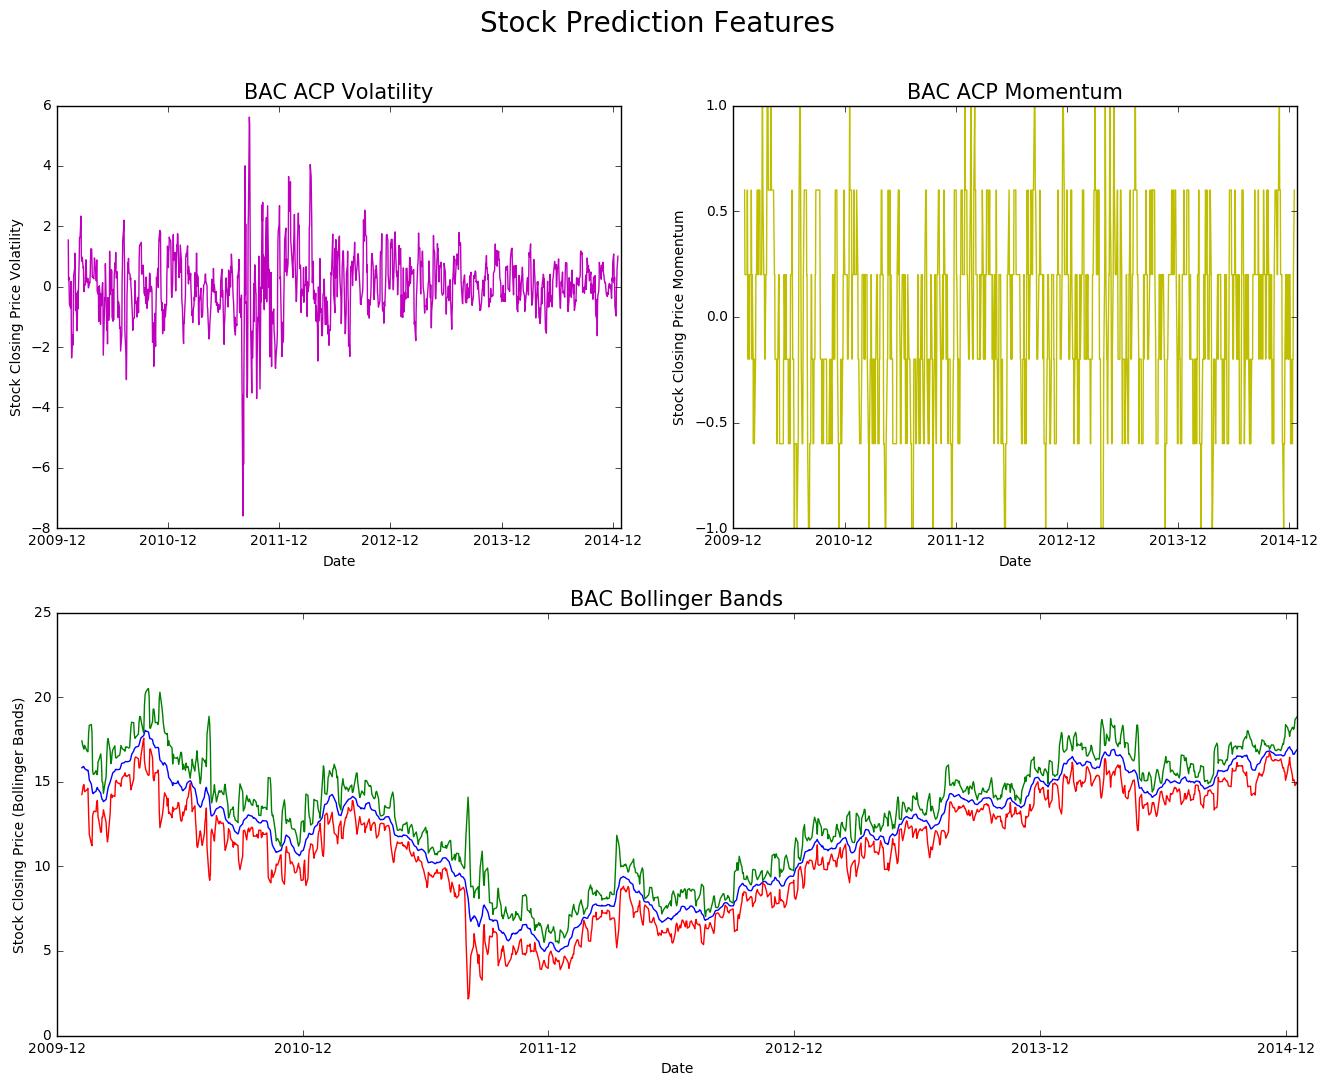

In [4]:
feature_data, target_data, pred_features, actual_acp, test_data, feature_fig = data_processing(data, 'BAC', 7, '2015-01-01', 5)

print [column for column in feature_data.columns]

In the above code we predict the ACP for BAC 7 trading days after the end of training on 2015-01-01 which corresponds to 2015-01-13. We collect data up to 2017-02-06 which leaves 527 trading days worth of test data that is unseen during training. For the training set we then compute our set of features: price volatility, price momentum, and Bollinger bands. We follow the approach in [2] to calculate price volatility and price momentum. Price volatility measures the tendency for price to change and is calculated by averaging (over the past 5 trading days) the day-to-day percent change in price. As an example we study the above visualization in the months before 2011-12 where we see a relatively large signal in the volatility; observing now the raw data visualization at around 2011-08 we see a likely cause -- a vertical drop of ~20% in BAC's ACP following news that AIG was suing BAC for $10 billion. The price momentum on the other hand measures the price's tendency to move in one direction. It is calculated by first assigning a +1 to a trading day if its ACP is higher than the previous day's or a -1 if it's ACP is less than the previous day's; the results are then averaged over the past 5 days. Lastly we calculate the Bollinger bands which are a  popular volatility indicator. There are 3 Bollinger bands, the middle band is simply the mean ACP over the last 5 trading days; in the same window we calculate the ACP's standard deviation and add (subtract) to the middle band to arrive at the upper (lower) Bollinger bands.

Because each feature uses a window over which to average price data, there are instances where a calculation can not be made because there is no data to average. Similarly when we shift the target data by the number of trading days to the prediction date we do not shift test data into the training set. Therefore the method chosen here is to trim the training set on the bottom (oldest data) by removing as many samples as days in the averaging window, and on the top (nearest the last training date) by the removing as many samples as numbers of days to the prediction date.

## Results

#### Model Evaluation and Validation
In order to understand how the model performs we use a form of cross-validation for time-series data. Cross-validation allows one to analyze a specific dataset and model to determine how well the model generalizes to an unseen dataset. As an example we describe typical k-fold cross-validation: first a dataset is split into k subsets with k-1 subsets being the training data and one subset being the test data. The model then trains on the training data and makes predictions based off the training and test data which is scored by some performance metric (relative price difference in our case). Training, predicting, and scoring is repeated k-times with different training and testing subsets each time. The scoring from the k different splits are then averaged to give the final score. 

In case of stock price prediction, we are working with time-series data which requires a different approach as we want the model to be sensitive to the underlying structure of the data rather than try to eliminate the sensitivity to it. The major reason being that the stock price's recent history is the most important factor in determining future stock prices. The strategy we adopt here is to first evenly split the time-series into $N$ subsets denoted by $0\leq n \leq N-1$. The $n=0$ subset corresponds with the oldest data in the dataset while $n=N-1$ is the most recent data. The model is trained on the oldest subset and predicts the stock prices for the next subset (i.e. train using features and targets in $n=0$, predict using features in $n=1$), the mean of the relative price difference in the whole subset is then computed and used as our performance metric. As we repeat this procedure we add successive subsets for training and continue until we predict on the $n=N-1$ subset at which point our training set includes the subsets $n=0,1,2,...,N-2$. The following figure displays 3 plots that demonstrate the time-series cross-validation used. The first figure is contains the oldest data in the dataset and correponds to $n=0$ and $n=1$ subsets. The next two plots contains half the training data and all the training data respectively.

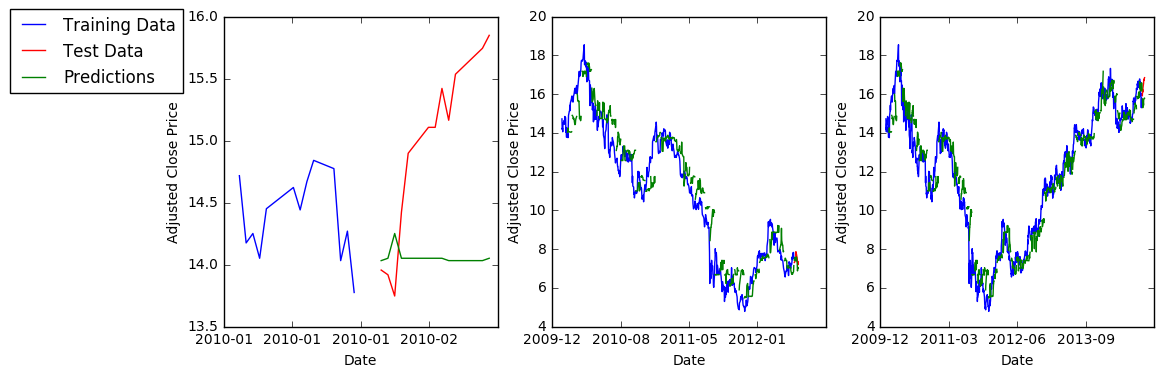

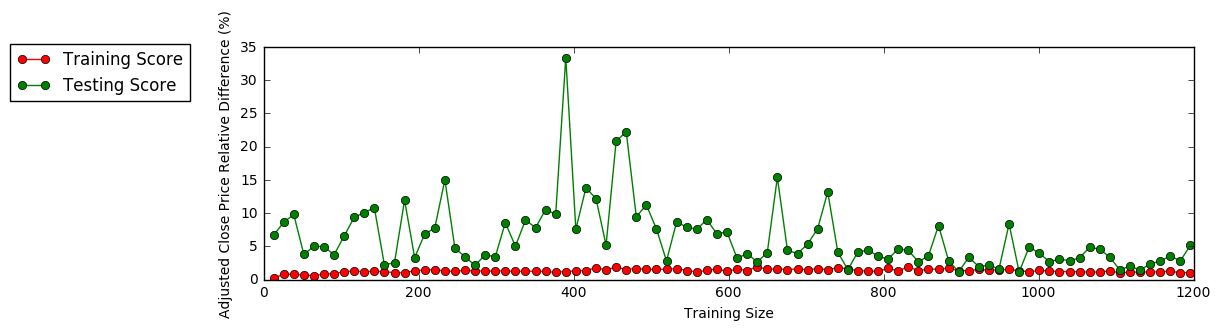

In [5]:
cv_data = time_series_cv(len(feature_data), 93)

regr_params, train_preds, train_folds, test_preds, test_folds, feature_folds = cross_validation(feature_data, target_data, \
                                                                                                cv_data)
fold_fig, fold_ax = fold_plotter(train_folds, test_folds, test_preds)
learn_fig, learn_ax = learning_curve(test_preds, test_folds, train_preds, train_folds )

To analyze how well our model performs over varying training set size we build a learning curve from the time-series cross-validation data. The training score is the mean relative difference between training feature predictions and corresponding training targets, while the testing score is the mean relative difference between test data predictions and test data targets. In the above example we produce 93 folds which gives 92 prediction folds each containing 12 trading days. We find our testing score performs relatively poorly near 400 trading days, we attribute this to the previously noted drop in BAC's stock price of 20% following the AIG lawsuit. Otherwise we find that after about 800 trading days our testing predictions appear as accurate as our training predictions, both of which lie below 5% relative price difference.
Next we analyze the model parameters by a grid search using the above cross-validation fold technique. The major parameters available to us via scikit-learn's AdaBoostRegressor are the max depth of the Decision Tree Regressor (base estimator), the number of weak learners (n_estimators), and the learning rate. The result of the grid-search is visualized below in a complexity graph where the combined folds' mean score (from our performance metric) is plotted against each tuning paramter; the shaded regions represent the combined folds' corresponding standard deviation.

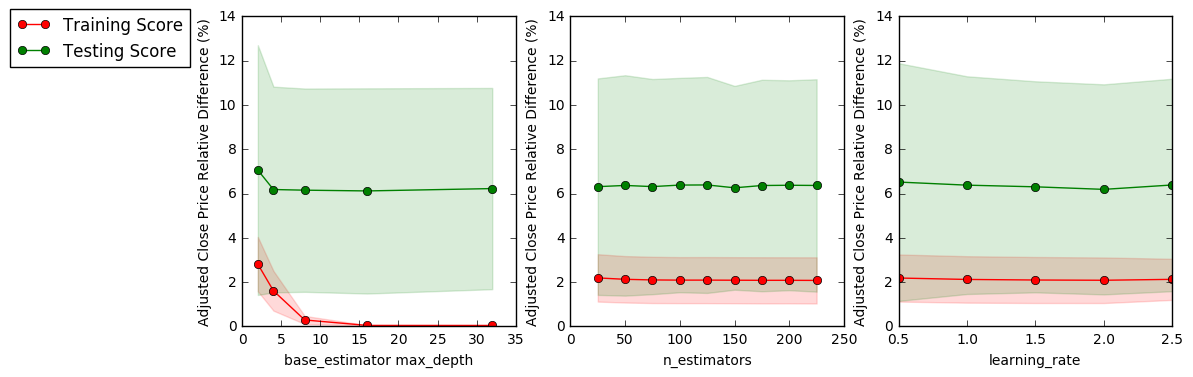

In [6]:
com_fig, com_ax = model_complexity(feature_data, target_data, cv_data)

For each parameter we find that testing score performance is relatively insensitive to tuning. While we find that as we increase the tree depth of our base estimator the model fits the training data exceptionally well at the expense of a slight decrease in testing performance, indicating overfitting. Additionally the standard deviation for each paramter's score is large, likely due to a combination of the data volatility and the lack of training examples in the earlier folds which leads to poor predictions. To see the magnitude of the latter effect we repeat the above measurements but only plot the mean and standard deviations for the latter half of the folds (e.g. folds 47 to 93).

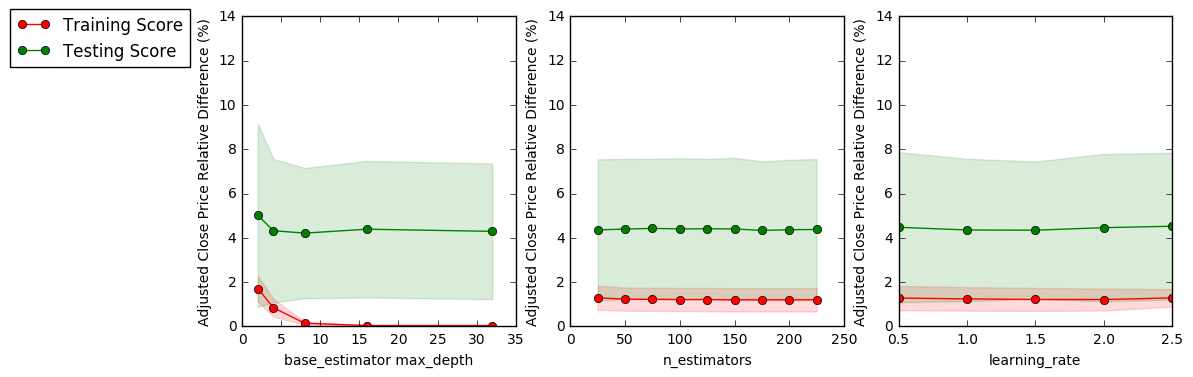

In [7]:
part_fig, part_ax = model_complexity_partial(feature_data, target_data, cv_data)

The early dataset has a bigger effect on the mean score for the folds considering we improve on the relative difference by 30% when we analyze only the latter half. The standard deviation is only slightly improved (~5%) which could reflect the uncertainty in predicting random data. Based on these results we use the following parameters: max_depth: 16, n_estimators: 150, learning_rate: 2 to predict the stock price 7 trading days into the "future" (2015-01-13).

### Refinement

Based on the above results we use the following parameters: max_depth: 16, n_estimators: 150, learning_rate: 2 to predict the stock price 7 trading days into the "future" (2015-01-13). While further tweaks are possible, for example the AdaBoost loss function and specifying the minimum samples to split a node in the base estimator, we see from the above results that the time series limits our generalization performance and therefore expect marginal performance gain at the expense of much longer run times. 

In [6]:
regr_params = {'base_estimator':DecisionTreeRegressor(max_depth = 16), 'n_estimators':150, 'learning_rate':2, 'random_state':99}
pred_price = fit_pred_price(feature_data, target_data, pred_features, regr_params)
print 'Actual price: {} , Predicted price: {}'.format(actual_acp['adj_close_BAC'], pred_price)
print 'Prediction Relative Difference: {}'.format(performance_metric(actual_acp['adj_close_BAC'], pred_price))

Actual price: 16.0062614177 , Predicted price: 16.9733184157
Prediction Relative Difference: 5.69751285114


#### Free-form visualization and Justification
We can extend the above model to predict an arbitrary number of days into the "future" so long as we have the dataset to measure the prediction results against which the following figure demonstrates.

Mean AdaBoost Score 8.05492951058 , Mean SVR Score 13.7010308733


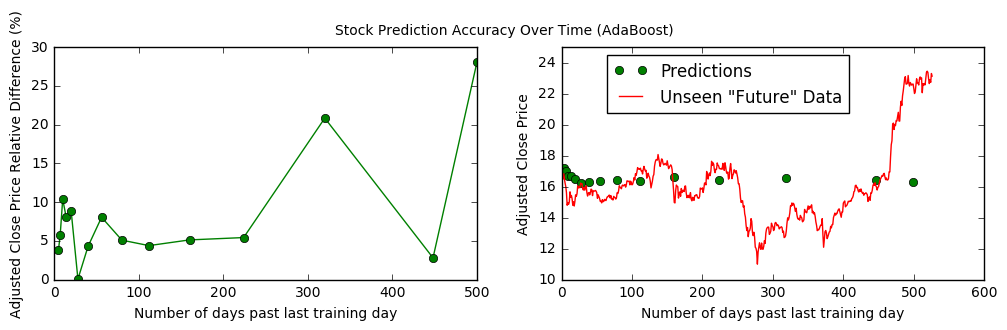

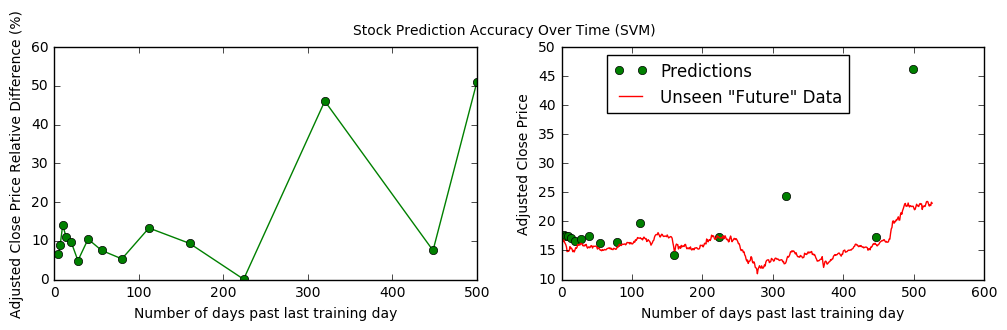

In [7]:
    pred_nums = [5, 7, 10, 14, 20, 28, 40, 56, 80, 112, 160, 224, 320, 448, 500]
    scores=[0]*len(pred_nums)
    svm_scores = [0]*len(pred_nums)
    
    last_train_price = target_data.iloc[0]
    pred_fig, pred_ax = plt.subplots(1,2, figsize = (12,3), dpi=50)
    svm_fig, svm_ax = plt.subplots(1,2, figsize = (12,3), dpi=50)
    
    for i,day in enumerate(pred_nums):
        feature_data, target_data, pred_features, actual_price, test_data = data_processing_nofig(data, 'BAC', day, '2015-01-01', 5)
        regr_params = {'base_estimator': DecisionTreeRegressor(max_depth=16), 'n_estimators':150, 'learning_rate':2, \
                       'random_state':99}
        svm_params = {'C':4096 , 'gamma': 2**(-22)}
        
        pred_price = fit_pred_price(feature_data, target_data, pred_features, regr_params)
        svm_pred = svm_pred_price(feature_data, target_data, pred_features, svm_params)
        
        scores[i] = performance_metric(actual_price['adj_close_BAC'], pred_price)
        svm_scores[i] = performance_metric(actual_price['adj_close_BAC'], svm_pred)
        
        pred_index = np.where(test_data.index==actual_price.name)
        
        pred_arr = np.zeros(len(test_data.index))
        svm_arr = np.zeros(len(test_data.index))
        
        np.put(pred_arr,pred_index, pred_price)
        np.put(svm_arr, pred_index, svm_pred)
        
        if i==0:
            pred_ax[1].plot(range(len(test_data.index)), pred_arr[::-1], 'o', color = 'g', label = 'Predictions')
            svm_ax[1].plot(range(len(test_data.index)), svm_arr[::-1], 'o', color = 'g', label = 'Predictions')
        else:
            pred_ax[1].plot(range(len(test_data.index)), pred_arr[::-1], 'o', color = 'g')
            svm_ax[1].plot(range(len(test_data.index)), svm_arr[::-1], 'o', color = 'g')
    print 'Mean AdaBoost Score {} , Mean SVR Score {}'.format(np.mean(scores), np.mean(svm_scores))
    pred_ax[0].plot(pred_nums, scores ,'o-', color='g')
    pred_fig.suptitle('Stock Prediction Accuracy Over Time (AdaBoost)')
    pred_ax[0].set_ylabel('Adjusted Close Price Relative Difference (%)')
    pred_ax[0].set_xlabel('Number of days past last training day')
    pred_ax[1].plot(range(len(test_data.index)), test_data['adj_close_BAC'][::-1],color = 'r',  label = 'Unseen "Future" Data')
    pred_ax[1].set_ylim((10,25))
    pred_ax[1].set_ylabel('Adjusted Close Price')
    pred_ax[1].set_xlabel('Number of days past last training day')
    pred_ax[1].legend( bbox_to_anchor=(.7, 1))
    
    svm_ax[0].plot(pred_nums, svm_scores ,'o-', color='g')
    svm_fig.suptitle('Stock Prediction Accuracy Over Time (SVM)')
    svm_ax[0].set_ylabel('Adjusted Close Price Relative Difference (%)')
    svm_ax[0].set_xlabel('Number of days past last training day')
    svm_ax[1].plot(range(len(test_data.index)), test_data['adj_close_BAC'][::-1],color = 'r',  label = 'Unseen "Future" Data')
    svm_ax[1].set_ylim((10,50))
    svm_ax[1].set_ylabel('Adjusted Close Price')
    svm_ax[1].set_xlabel('Number of days past last training day')
    svm_ax[1].legend( bbox_to_anchor=(.7, 1))



When we do not average over a number of trading days, as was done in the learning and model complexity curves, we find that the relative difference can be quite large depending on how the stock actually behaves, considering that 10, 14, and 20 days from the last training date we have a relative difference $>2$ times the amount we saw in averaging over 12 trading days. Furthermore we find that with the current features, the last training date plays a very important role considering that after 500 days the predictions do not stray from their early values. When comparing the results between the AdaBoost model and SVR, AdaBoost generally performs better over the given test data (8.0% vs 13.7% mean score). In inspecting each sample's score, we see that SVR performs worse than AdaBoost by a factor ~2 throughout the test data. This is borne out when we compare predictions to the test time series where SVR has more variance about an ACP mean of ~16 while AdaBoost tends to an ACP near 16 over the full test data.

## Conclusion

#### Reflection and Improvement

In the following notebook we have developed a machine learning approach to the problem of predicting stock prices. We began by addressing the difficulty in predicting stock market trends due to the random-walk nature of stock prices described by the efficient market hypothesis. Working with the intrinio web-API we then analyzed the raw price data for a few company stocks and indices before computing our set of features and describing in detail the algorithm behind AdaBoost regression. We then addressed the problem of cross-validation with time-series data, which happened to bring the most difficulty as using a random k-fold cross-validation produced results for which analysis did not make sense. A re-thinking of the problem in terms of capturing historical trends rather than simply using decision trees to describe numerous outcomes was required and therefor research into how to perform cross-validation on time-series data. Additionally, difficulties arose during data processing stage as care had to be taken in implementing how exactly to predict a given number of days into the future, and how to sort and trim the data. If not done carefully the model could be training on test data and perform exceedingly well on the same test data. Lastly, we then compare AdaBoost and SVR models on identical sets of data and measure their performance.

Using the AdaBoost ensemble method we are able to make predictions that typically fall within 6% of the actual ACP. Furthermore we accomplish this using a relatively small dataset consisting of just 2 market indices and 4 company stocks with 3 distinct features, giving us 1,786 trading days each with 30 total features. While the time-series cross-validation allowed us to analyze in-depth our model, the results were a bit misleading considering that early predictions based off a few number of training samples weighed heavily on the final scoring. In the future this technique could be refined by using a larger historical dataset and analyzing only predictions that have been made on a suitable number of training samples (around 600 in our case). Similarly there are a number of other technical indicators including patterns that could be used to improve prediction accuracy in the short and long term. 
One could also increase the scope of the model in a number of ways: 
* Increasing the dataset by orders of magnitude by sampling at sub-day intervals (provided by pay-to-use Bloomberg terminal for example) which would allow the model to train on data closer to the prediction date. 
* Supplement the regression model with a classification model to predict whether the price simply increases or decreases relative to a given date. 
* Incorporate news feed scrapers and natural language processing to measure the relevance and good-ness of news which are incorporated as features.

For the current results though, improvements could be made by simply including more company stocks from the S&P indices as well as incorporating features that use data beyond the ACP.

### References
[1] Harris Drucker, *Improving Regressors using Boosting Techniques *, ICML '97 Proceedings of the Fourteenth International Conference on Machine Learning (1997).

[2] Saahil Madge, *Predicting Stock Price Direction using Support Vector Machines*, (2015)

[3] Xinjie Di, *Stock Trend Prediction with Technical Indicators using SVM*, (2014)

[4] Hui Lin, *Feature Investigation for Stock market Prediction*, (2013)

[5] StockCharts.com, *Introduction to Technical Indicators and Oscillators*, https://tinyurl.com/jdwmvw2